# Optimized Weather Prediction Model

In [329]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Prep

In [342]:
weather = pd.read_csv("pwm_weather.csv", index_col="DATE")

In [343]:
#core data values noted by the NOAA
core_weather = weather[["PRCP","SNOW","SNWD","TMAX","TMIN"]].copy()
core_weather.columns = ["precip", "snow", "snow_depth", "temp_max", "temp_min"]

In [344]:
core_weather.apply(pd.isnull).sum()/weather.shape[0]

precip        0.000042
snow          0.000542
snow_depth    0.005880
temp_max      0.000042
temp_min      0.000042
dtype: float64

In [345]:
core_weather["snow_depth"] = core_weather["snow_depth"].fillna(0)

In [346]:
core_weather = core_weather.ffill()

In [347]:
core_weather.apply(pd.isnull).sum()/weather.shape[0]

precip        0.0
snow          0.0
snow_depth    0.0
temp_max      0.0
temp_min      0.0
dtype: float64

In [348]:
core_weather.dtypes

precip        float64
snow          float64
snow_depth    float64
temp_max      float64
temp_min      float64
dtype: object

In [349]:
core_weather.index

Index(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04', '1960-01-05',
       '1960-01-06', '1960-01-07', '1960-01-08', '1960-01-09', '1960-01-10',
       ...
       '2025-08-15', '2025-08-16', '2025-08-17', '2025-08-18', '2025-08-19',
       '2025-08-20', '2025-08-21', '2025-08-22', '2025-08-23', '2025-08-24'],
      dtype='object', name='DATE', length=23978)

In [350]:
core_weather.index = pd.to_datetime(core_weather.index)

In [351]:
core_weather.index

DatetimeIndex(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04',
               '1960-01-05', '1960-01-06', '1960-01-07', '1960-01-08',
               '1960-01-09', '1960-01-10',
               ...
               '2025-08-15', '2025-08-16', '2025-08-17', '2025-08-18',
               '2025-08-19', '2025-08-20', '2025-08-21', '2025-08-22',
               '2025-08-23', '2025-08-24'],
              dtype='datetime64[ns]', name='DATE', length=23978, freq=None)

In [352]:
core_weather.index.year

Index([1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960,
       ...
       2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025],
      dtype='int32', name='DATE', length=23978)

In [353]:
core_weather.apply(lambda x: (x==9999).sum())

precip        0
snow          0
snow_depth    0
temp_max      0
temp_min      0
dtype: int64

<Axes: xlabel='DATE'>

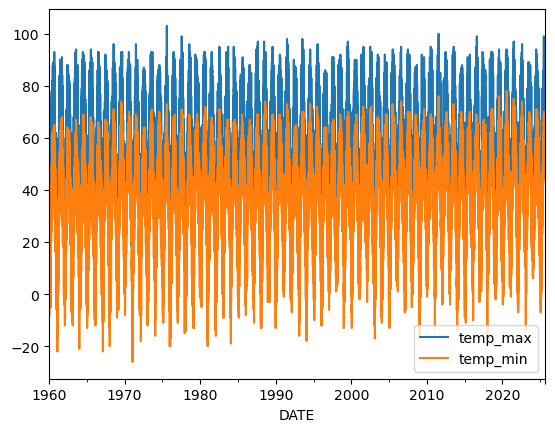

In [354]:
core_weather[["temp_max","temp_min"]].plot()

In [355]:
core_weather.index.year.value_counts().sort_index()

DATE
1960    366
1961    365
1962    365
1963    365
1964    366
       ... 
2021    365
2022    365
2023    365
2024    366
2025    236
Name: count, Length: 66, dtype: int64

In [356]:
# how much it __ each year
core_weather.groupby(core_weather.index.year).sum()

,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,
1960,43.21,94.0,719.0,20342.0,12668.0
1961,38.75,86.9,540.0,20158.0,12626.0
1962,46.33,81.2,672.0,19770.0,11946.0
1963,38.59,82.4,1163.0,20182.0,12028.0
1964,34.59,78.6,481.0,20232.0,12150.0
...,...,...,...,...,...
2021,44.92,33.4,246.3,21076.0,14675.0
2022,46.66,36.6,197.3,21051.0,14210.0
2023,56.67,52.5,375.2,20898.0,14818.0


In [357]:
#create column w tomorrow's temperature as "target" -> ensure prediction for tmrw's temp is based on prev data
core_weather["target"] = core_weather.shift(-1)["temp_max"]

In [358]:
# get rid of last row w/ NaN target
core_weather = core_weather.iloc[:-1,:].copy()

In [359]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target
DATE,,,,,,
1960-01-01,0.00,0.0,11.0,34.0,6.0,37.0
1960-01-02,0.00,0.0,9.0,37.0,0.0,48.0
1960-01-03,1.27,0.0,7.0,48.0,36.0,37.0
1960-01-04,0.00,0.0,1.0,37.0,27.0,33.0
1960-01-05,0.00,0.0,1.0,33.0,15.0,27.0
...,...,...,...,...,...,...
2025-08-19,0.00,0.0,0.0,71.0,51.0,67.0
2025-08-20,0.03,0.0,0.0,67.0,51.0,71.0
2025-08-21,0.00,0.0,0.0,71.0,46.0,83.0


In [360]:
reg = Ridge(alpha = .1)

In [361]:
predictors = ["precip", "temp_max", "temp_min"]

In [362]:
train = core_weather.loc[:"2020-12-31"]

In [363]:
test = core_weather.loc["2021-01-01":]

In [364]:
reg.fit(train[predictors],train["target"])

Ridge(alpha=0.1)

In [365]:
predictions = reg.predict(test[predictors])

In [366]:
mean_absolute_error(test["target"],predictions)

5.792190056346174

In [367]:
# evaluating model by comparing actual vs prediction
combined = pd.concat([test["target"],pd.Series(predictions, index = test.index)], axis = 1)
combined.columns = ["actual","predictions"]

In [368]:
combined

,actual,predictions
DATE,,
2021-01-01,38.0,36.575989
2021-01-02,31.0,41.157857
2021-01-03,36.0,35.308081
2021-01-04,32.0,40.007745
2021-01-05,38.0,37.601726
...,...,...
2025-08-19,67.0,69.878045
2025-08-20,71.0,67.196813
2025-08-21,83.0,68.501978


<Axes: xlabel='DATE'>

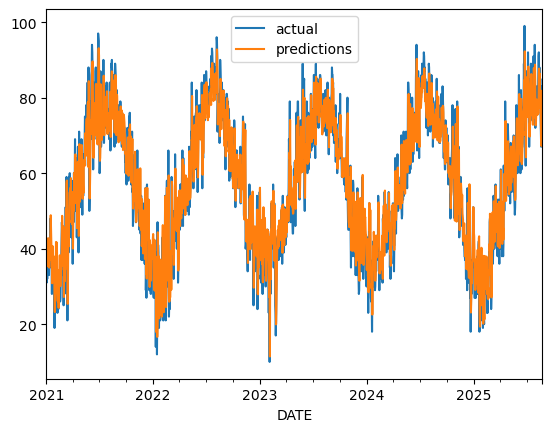

In [369]:
combined.plot()

In [370]:
reg.coef_

array([-0.74514766,  0.66471945,  0.27521331])

In [371]:
def create_predictions(predictors, core_weather, req):
    train = core_weather.loc[:"2020-12-31"]
    test = core_weather.loc["2021-01-01":]
    reg.fit(train[predictors],train["target"])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test["target"], predictions)                             
    combined = pd.concat([test["target"], pd.Series(predictions, index = test.index)], axis = 1)
    combined.columns = ["actual", "predictions"]
    return error, combined

In [372]:
# average temp of each month
core_weather["month_max"] = core_weather["temp_max"].rolling(30).mean()

In [373]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target,month_max
DATE,,,,,,,
1960-01-01,0.00,0.0,11.0,34.0,6.0,37.0,NaN
1960-01-02,0.00,0.0,9.0,37.0,0.0,48.0,NaN
1960-01-03,1.27,0.0,7.0,48.0,36.0,37.0,NaN
1960-01-04,0.00,0.0,1.0,37.0,27.0,33.0,NaN
1960-01-05,0.00,0.0,1.0,33.0,15.0,27.0,NaN
...,...,...,...,...,...,...,...
2025-08-19,0.00,0.0,0.0,71.0,51.0,67.0,81.033333
2025-08-20,0.03,0.0,0.0,67.0,51.0,71.0,80.800000
2025-08-21,0.00,0.0,0.0,71.0,46.0,83.0,80.666667


In [374]:
core_weather = core_weather.iloc[30:,:].copy()

In [375]:
# replace cell w/ temp_max val of 0 with the temp_max of the previous day
core_weather.loc[core_weather["temp_max"] == 0, "temp_max"] = (core_weather["temp_max"].shift())

In [376]:
# difference for avg monthly temp vs temp in a given day
core_weather["month_day_max"] = core_weather["month_max"] / core_weather["temp_max"]

In [377]:
core_weather["range"] = core_weather["temp_max"] - core_weather["temp_min"]

In [378]:
core_weather["avg_temp"] = (core_weather["temp_max"] + core_weather["temp_min"]) / 2

In [379]:
predictors = ["precip", "temp_max", "temp_min", "month_max", "month_day_max", "range", "avg_temp"]

In [380]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,range,avg_temp
DATE,,,,,,,,,,
1960-01-31,0.00,0.0,9.0,22.0,12.0,24.0,32.866667,1.493939,10.0,17.0
1960-02-01,0.00,0.0,9.0,24.0,5.0,26.0,32.433333,1.351389,19.0,14.5
1960-02-02,0.01,0.4,9.0,26.0,17.0,42.0,31.700000,1.219231,9.0,21.5
1960-02-03,0.13,2.8,12.0,42.0,25.0,50.0,31.866667,0.758730,17.0,33.5
1960-02-04,0.00,0.0,8.0,50.0,19.0,37.0,32.433333,0.648667,31.0,34.5
...,...,...,...,...,...,...,...,...,...,...
2025-08-19,0.00,0.0,0.0,71.0,51.0,67.0,81.033333,1.141315,20.0,61.0
2025-08-20,0.03,0.0,0.0,67.0,51.0,71.0,80.800000,1.205970,16.0,59.0
2025-08-21,0.00,0.0,0.0,71.0,46.0,83.0,80.666667,1.136150,25.0,58.5


In [381]:
core_weather.apply(np.isinf).sum()/weather.shape[0]

precip           0.0
snow             0.0
snow_depth       0.0
temp_max         0.0
temp_min         0.0
target           0.0
month_max        0.0
month_day_max    0.0
range            0.0
avg_temp         0.0
dtype: float64

In [382]:
core_weather[core_weather["temp_max"] == 0]

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,range,avg_temp
DATE,,,,,,,,,,


In [383]:
core_weather.apply(np.isinf).sum()/weather.shape[0]

precip           0.0
snow             0.0
snow_depth       0.0
temp_max         0.0
temp_min         0.0
target           0.0
month_max        0.0
month_day_max    0.0
range            0.0
avg_temp         0.0
dtype: float64

In [384]:
core_weather[np.isinf(core_weather["month_day_max"])]

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,range,avg_temp
DATE,,,,,,,,,,


In [385]:
core_weather.apply(pd.isnull).sum()/weather.shape[0]

precip           0.0
snow             0.0
snow_depth       0.0
temp_max         0.0
temp_min         0.0
target           0.0
month_max        0.0
month_day_max    0.0
range            0.0
avg_temp         0.0
dtype: float64

In [386]:
error, combined = create_predictions(predictors, core_weather, reg)

In [387]:
error

5.574334453858657

<Axes: xlabel='DATE'>

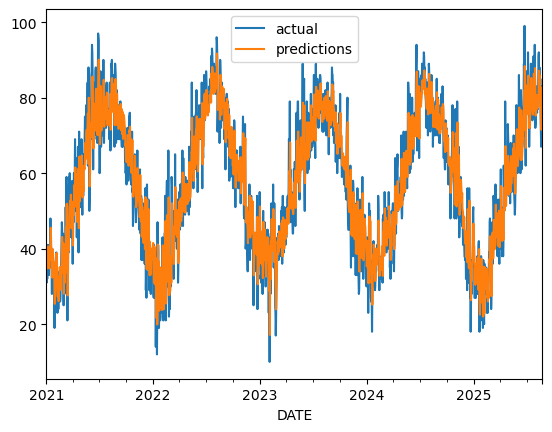

In [388]:
combined.plot()

In [389]:
# use previous rows temp in the same month to calc the mean for each day
core_weather["month_avg"] = (
    core_weather.groupby(core_weather.index.month)["temp_max"]
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
)

In [390]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,range,avg_temp,month_avg
DATE,,,,,,,,,,,
1960-01-31,0.00,0.0,9.0,22.0,12.0,24.0,32.866667,1.493939,10.0,17.0,22.000000
1960-02-01,0.00,0.0,9.0,24.0,5.0,26.0,32.433333,1.351389,19.0,14.5,24.000000
1960-02-02,0.01,0.4,9.0,26.0,17.0,42.0,31.700000,1.219231,9.0,21.5,25.000000
1960-02-03,0.13,2.8,12.0,42.0,25.0,50.0,31.866667,0.758730,17.0,33.5,30.666667
1960-02-04,0.00,0.0,8.0,50.0,19.0,37.0,32.433333,0.648667,31.0,34.5,35.500000
...,...,...,...,...,...,...,...,...,...,...,...
2025-08-19,0.00,0.0,0.0,71.0,51.0,67.0,81.033333,1.141315,20.0,61.0,77.923304
2025-08-20,0.03,0.0,0.0,67.0,51.0,71.0,80.800000,1.205970,16.0,59.0,77.917936
2025-08-21,0.00,0.0,0.0,71.0,46.0,83.0,80.666667,1.136150,25.0,58.5,77.914538


In [391]:
core_weather["day_of_year_avg"] = core_weather["temp_max"].groupby(core_weather.index.day_of_year).transform(lambda x: x.expanding(1).mean())

In [392]:
predictors = ["precip", "temp_max", "temp_min", "month_max", "month_day_max", "range", "avg_temp", "month_avg", "day_of_year_avg"]

In [393]:
error, combined = create_predictions(predictors, core_weather, reg)

In [394]:
error

5.30841006657842

In [395]:
reg.coef_

array([-0.25304501,  0.23765132,  0.12709555,  0.03456584, -0.45290127,
        0.11055573,  0.1823735 ,  0.15508366,  0.26157501])

In [396]:
core_weather.corr()["target"]

precip            -0.027116
snow              -0.228935
snow_depth        -0.462984
temp_max           0.907107
temp_min           0.872903
target             1.000000
month_max          0.867180
month_day_max     -0.240996
range              0.182244
avg_temp           0.909030
month_avg          0.887757
day_of_year_avg    0.898892
Name: target, dtype: float64

In [397]:
combined["diff"] = (combined["actual"] - combined["predictions"]).abs()

In [398]:
combined.sort_values("diff", ascending = False).head()

,actual,predictions,diff
DATE,,,
2025-04-18,79.0,53.498450,25.501550
2022-02-22,66.0,43.216631,22.783369
2021-12-10,56.0,33.286792,22.713208
2023-06-02,55.0,77.557782,22.557782
2022-01-16,47.0,24.854267,22.145733


In [399]:
# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5]
}

In [400]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest with GridSearchCV

In [401]:
# Create and tune Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

In [402]:
train_enhanced = core_weather.loc[:"2020-12-31"]

In [403]:
test_enhanced = core_weather.loc["2021-01-01":]

In [404]:
rf_grid.fit(train_enhanced[predictors],train_enhanced["target"])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/linhnguyen/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['sqrt', 'log2', 0.5],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [416]:
print("Best Random Forest parameters:", rf_grid.best_params_)
print("Best RF CV score:", -rf_grid.best_score_)    

Best Random Forest parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 300}
Best RF CV score: 5.471794974283213


In [418]:
# Make predictions
rf_predictions = rf_grid.predict(test_enhanced[predictors])
rf_mae = mean_absolute_error(test_enhanced["target"], rf_predictions)
print(f"Random Forest Test MAE: {rf_mae:.4f}")

Random Forest Test MAE: 5.2645


# Gradient Boosting with GridSearchCV

In [405]:
# Gradient Boosting hyperparameter grid
gb_param_grid = {
'n_estimators': [100, 200, 300],
'learning_rate': [0.05, 0.1, 0.2],
'max_depth': [3, 5, 7],
'subsample': [0.8, 0.9, 1.0],
'min_samples_split': [5, 10, 20]
}

In [406]:
# Create and tune Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(
    gb,
    gb_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

In [408]:
gb_grid.fit(train_enhanced[predictors], train_enhanced["target"])

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/linhnguyen/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [420]:
print("Best Gradient Boosting parameters:", gb_grid.best_params_)
print("Best GB CV score:", -gb_grid.best_score_)

Best Gradient Boosting parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
Best GB CV score: 5.48051173688587


In [422]:
# Make predictions
gb_predictions = gb_grid.predict(test_enhanced[predictors])
gb_mae = mean_absolute_error(test_enhanced["target"], gb_predictions)
print(f"Gradient Boosting Test MAE: {gb_mae:.4f}")

Gradient Boosting Test MAE: 5.2787


# Model Comparison

In [413]:
def compare_models(test_data, predictions_dict):
    """Compare multiple models and return performance metrics"""
    results = {}

    for model_name, predictions in predictions_dict.items():
        mae = mean_absolute_error(test_data["target"], predictions)
        mse = mean_squared_error(test_data["target"], predictions)
        r2 = r2_score(test_data["target"], predictions)

        results[model_name] = {
          'MAE': mae,
          'RMSE': np.sqrt(mse),
          'R²': r2
      }

    return pd.DataFrame(results).T.round(4)

In [423]:
predictions_comparison = {
  'Ridge': reg.predict(test_enhanced[predictors]),
  'Random Forest': rf_predictions,
  'Gradient Boosting': gb_predictions
}

In [424]:
comparison_df = compare_models(test_enhanced, predictions_comparison)
print(comparison_df)

                      MAE    RMSE      R²
Ridge              5.3084  6.7984  0.8599
Random Forest      5.2645  6.7259  0.8629
Gradient Boosting  5.2787  6.7567  0.8616
